In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler # For learning rate scheduling
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

sns.set_theme(style="whitegrid")
print(f"PyTorch Version: {torch.__version__}")
print(f"Torchvision Version: {torchvision.__version__}")

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PyTorch Version: 2.3.0+cu118
Torchvision Version: 0.18.0+cu118
Using device: cuda


<p>Effective training of deep neural networks involves more than just basic Gradient Descent.</p>

1. Advanced Optimization Algorithms
2. Learning Rate Scheduling
3. Regularization Techniques

In [2]:
transform_reg = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,))      # mean and std for FashionMNIST (approx)
])

In [3]:
transform_reg

Compose(
    ToTensor()
    Normalize(mean=(0.286,), std=(0.353,))
)

In [8]:
batch_size_reg = 128

train_dataset_or = torchvision.datasets.FashionMNIST(root="./data", train=True,
                                             download=True, transform=transform_reg)
test_or = torchvision.datasets.FashionMNIST(root="./data", train=False,
                                            download=True, transform=transform_reg)

In [9]:
train_size_or = int(0.8 * len(train_dataset_or))
val_size_or = len(train_dataset_or) - train_size_or
train_or, val_or = random_split(train_dataset_or, [train_size_or, val_size_or],
                                generator=torch.Generator().manual_seed(42))

In [10]:
train_loader_or = DataLoader(train_or, batch_size=batch_size_reg, shuffle=True, num_workers=2)
val_loader_or = DataLoader(val_or, batch_size=batch_size_reg, shuffle=False, num_workers=2)
test_loader_or = DataLoader(test_or, batch_size=batch_size_reg, shuffle=False, num_workers=2)


In [11]:
classes_or = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
N_CLASSES_OR = len(classes_or)
FLATTENED_DIM_OR = 28 * 28

In [15]:
print(f"Train samples: {len(train_or)}, Val samples: {len(val_or)}, Test samples: {len(test_or)}")

Train samples: 48000, Val samples: 12000, Test samples: 10000


In [16]:
# simple MLP model
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim, dropout_rate=0.0):
        super(SimpleMLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate) 
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_dim2, output_dim) # Output logits

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.fc1(x))
        x = self.dropout1(x) 
        x = self.relu2(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [17]:
HIDDEN_DIM1 = 256
HIDDEN_DIM2 = 128

### Optimization Algorithms

#### Stochastic Gradient Descent (SGD)
<p>We'll use this as a baseline to compare with Adam. SGD with momentum is often better than vanilla SGD.</p>

#### Adam Optimizer
<p>Adam (Adaptive Moment Estimation) is an adaptive learning rate optimization algorithm that computes individual learning rates for different parameters. It combines ideas from RMSProp (adaptive learning rates based on squared gradients) and Momentum (using a moving average of gradients). Ofter a good default choice for many deep learning tasks. Common parameters: lr (learning rate), betas (coefficients for moving averages), eps (for numerical stability).</p>

In [18]:
def train_and_validate_model(model_instance, model_name,
                             train_dl, val_dl,
                             optimizer_instance, criterion_instance,
                             scheduler_instance=None, num_epochs=10):
    print(f"\n--- Training {model_name} with Optimizer: {type(optimizer_instance).__name__} ---")
    history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}

    for epoch in range(num_epochs):
        model_instance.train() # Set model to training mode
        running_train_loss = 0.0
        for inputs, labels in train_dl:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer_instance.zero_grad()
            outputs_logits = model_instance(inputs)
            loss = criterion_instance(outputs_logits, labels)
            loss.backward()
            optimizer_instance.step()
            running_train_loss += loss.item() * inputs.size(0)
        
        epoch_train_loss = running_train_loss / len(train_dl.dataset)
        history['train_loss'].append(epoch_train_loss)

        model_instance.eval() # Set model to evaluation mode
        running_val_loss = 0.0
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for inputs_v, labels_v in val_dl:
                inputs_v, labels_v = inputs_v.to(device), labels_v.to(device)
                outputs_logits_v = model_instance(inputs_v)
                loss_v = criterion_instance(outputs_logits_v, labels_v)
                running_val_loss += loss_v.item() * inputs_v.size(0)
                _, preds_v = torch.max(outputs_logits_v, 1)
                correct_val += (preds_v == labels_v).sum().item()
                total_val += labels_v.size(0)
        
        epoch_val_loss = running_val_loss / len(val_dl.dataset)
        history['val_loss'].append(epoch_val_loss)
        epoch_val_acc = correct_val / total_val if total_val > 0 else 0
        history['val_accuracy'].append(epoch_val_acc)

        current_lr_str = ""
        if scheduler_instance:
            current_lr_str = f", Current LR: {optimizer_instance.param_groups[0]['lr']:.1e}"
            scheduler_instance.step(epoch_val_loss if isinstance(scheduler_instance, lr_scheduler.ReduceLROnPlateau) else None)


        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}{current_lr_str}")
              
    return history

In [19]:
# Experiment: SGD vs Adam
epochs = 10
criterion = nn.CrossEntropyLoss()

In [20]:
# model for SGD
mlp_sgd = SimpleMLP(FLATTENED_DIM_OR, HIDDEN_DIM1, HIDDEN_DIM2, N_CLASSES_OR, dropout_rate=0.0).to(device)
optimizer_sgd = optim.SGD(mlp_sgd.parameters(), lr=0.01, momentum=0.9)
history_sgd = train_and_validate_model(mlp_sgd, "MLP with SGD + Momentum",
                            train_loader_or, val_loader_or,
                            optimizer_sgd, criterion,
                            num_epochs=epochs)


--- Training MLP with SGD + Momentum with Optimizer: SGD ---
Epoch 1/10 - Train Loss: 0.6546, Val Loss: 0.4558, Val Acc: 0.8357
Epoch 2/10 - Train Loss: 0.4028, Val Loss: 0.3951, Val Acc: 0.8564
Epoch 3/10 - Train Loss: 0.3603, Val Loss: 0.3619, Val Acc: 0.8706
Epoch 4/10 - Train Loss: 0.3317, Val Loss: 0.3547, Val Acc: 0.8707
Epoch 5/10 - Train Loss: 0.3116, Val Loss: 0.3383, Val Acc: 0.8768
Epoch 6/10 - Train Loss: 0.2928, Val Loss: 0.3364, Val Acc: 0.8796
Epoch 7/10 - Train Loss: 0.2757, Val Loss: 0.3188, Val Acc: 0.8863
Epoch 8/10 - Train Loss: 0.2624, Val Loss: 0.3250, Val Acc: 0.8829
Epoch 9/10 - Train Loss: 0.2492, Val Loss: 0.3151, Val Acc: 0.8835
Epoch 10/10 - Train Loss: 0.2369, Val Loss: 0.3049, Val Acc: 0.8924


In [21]:
# Model for Adam
mlp_adam = SimpleMLP(FLATTENED_DIM_OR, HIDDEN_DIM1, HIDDEN_DIM2, N_CLASSES_OR, dropout_rate=0.0).to(device)
optimizer_adam = optim.Adam(mlp_adam.parameters(), lr=0.001) # Adam often uses smaller LR
history_adam = train_and_validate_model(mlp_adam, "MLP with Adam",
                                      train_loader_or, val_loader_or,
                                      optimizer_adam, criterion,
                                      num_epochs=epochs)


--- Training MLP with Adam with Optimizer: Adam ---
Epoch 1/10 - Train Loss: 0.5129, Val Loss: 0.3856, Val Acc: 0.8613
Epoch 2/10 - Train Loss: 0.3598, Val Loss: 0.3474, Val Acc: 0.8715
Epoch 3/10 - Train Loss: 0.3227, Val Loss: 0.3496, Val Acc: 0.8711
Epoch 4/10 - Train Loss: 0.2935, Val Loss: 0.3161, Val Acc: 0.8868
Epoch 5/10 - Train Loss: 0.2751, Val Loss: 0.3117, Val Acc: 0.8887
Epoch 6/10 - Train Loss: 0.2531, Val Loss: 0.3127, Val Acc: 0.8853
Epoch 7/10 - Train Loss: 0.2404, Val Loss: 0.3208, Val Acc: 0.8866
Epoch 8/10 - Train Loss: 0.2246, Val Loss: 0.3353, Val Acc: 0.8781
Epoch 9/10 - Train Loss: 0.2141, Val Loss: 0.3283, Val Acc: 0.8882
Epoch 10/10 - Train Loss: 0.2033, Val Loss: 0.3338, Val Acc: 0.8872


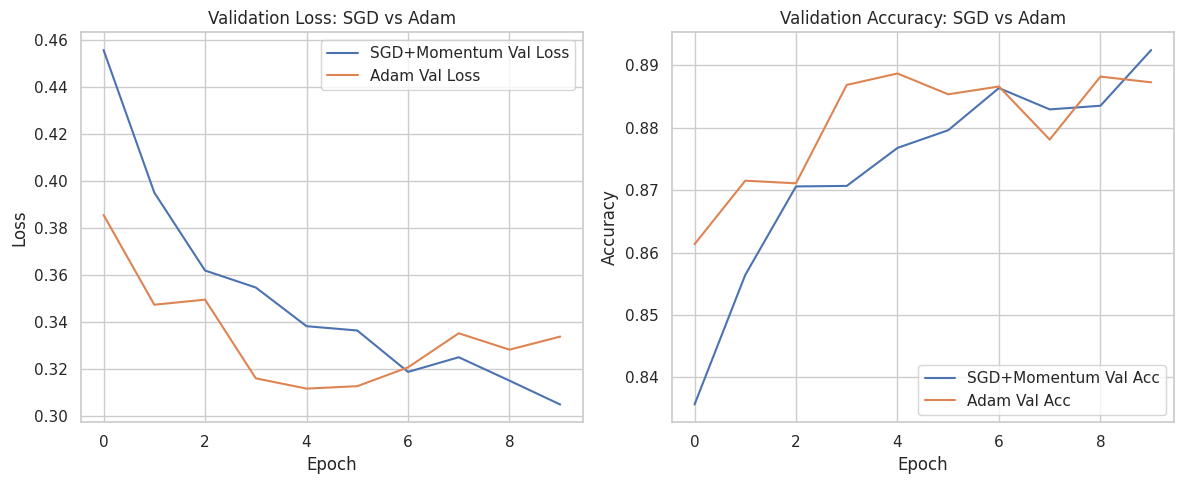

Adam often converges faster or to a better minimum than basic SGD.


In [22]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_sgd['val_loss'], label='SGD+Momentum Val Loss')
plt.plot(history_adam['val_loss'], label='Adam Val Loss')
plt.title('Validation Loss: SGD vs Adam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_sgd['val_accuracy'], label='SGD+Momentum Val Acc')
plt.plot(history_adam['val_accuracy'], label='Adam Val Acc')
plt.title('Validation Accuracy: SGD vs Adam')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()
print("Adam often converges faster or to a better minimum than basic SGD.")

### Learning Rate Scheduling
<p>Adjusting the learning rate during training can improve performance and convergence.</p>

- Start with a larger LR for faster initial progress.
- Gradually decrease LR as training progresses to allow for finer adjustments and avoid overshooting the minimum.

1. StepLR : Decays the learning rate by a factor (gamma) every `step_size` epochs.
2. ReduceLROnPlateau : Reduces learning rate when a metric (e.g. validation loss) has stopped improving.

In [23]:
mlp_lr_scheduler = SimpleMLP(FLATTENED_DIM_OR, HIDDEN_DIM1, HIDDEN_DIM2, N_CLASSES_OR).to(device)
optimizer_lr_scheduler = optim.Adam(mlp_lr_scheduler.parameters(), lr=0.001) # Initial LR

In [24]:
# decay lr by factor of 0.1 every 7 epochs
scheduler_step = lr_scheduler.StepLR(optimizer_lr_scheduler, step_size=7, gamma=0.1)

In [25]:
print("\nTraining MLP with Adam and StepLR Scheduler...")
history_lr_scheduler = train_and_validate_model(
    mlp_lr_scheduler, "MLP with Adam + StepLR",
    train_loader_or, val_loader_or,
    optimizer_lr_scheduler, criterion,
    scheduler_instance=scheduler_step,
    num_epochs=20 
)


Training MLP with Adam and StepLR Scheduler...

--- Training MLP with Adam + StepLR with Optimizer: Adam ---
Epoch 1/20 - Train Loss: 0.5064, Val Loss: 0.3921, Val Acc: 0.8591, Current LR: 1.0e-03
Epoch 2/20 - Train Loss: 0.3634, Val Loss: 0.3802, Val Acc: 0.8640, Current LR: 1.0e-03
Epoch 3/20 - Train Loss: 0.3231, Val Loss: 0.3387, Val Acc: 0.8763, Current LR: 1.0e-03
Epoch 4/20 - Train Loss: 0.2949, Val Loss: 0.3651, Val Acc: 0.8639, Current LR: 1.0e-03
Epoch 5/20 - Train Loss: 0.2753, Val Loss: 0.3276, Val Acc: 0.8807, Current LR: 1.0e-03
Epoch 6/20 - Train Loss: 0.2555, Val Loss: 0.3184, Val Acc: 0.8871, Current LR: 1.0e-03
Epoch 7/20 - Train Loss: 0.2410, Val Loss: 0.3237, Val Acc: 0.8851, Current LR: 1.0e-03
Epoch 8/20 - Train Loss: 0.1923, Val Loss: 0.2916, Val Acc: 0.8974, Current LR: 1.0e-04
Epoch 9/20 - Train Loss: 0.1810, Val Loss: 0.2899, Val Acc: 0.8996, Current LR: 1.0e-04
Epoch 10/20 - Train Loss: 0.1760, Val Loss: 0.2886, Val Acc: 0.8990, Current LR: 1.0e-04
Epoch 11/

### Regularization Techniques
<p>Regularization helps prevent overfitting by adding constraints or penalties to the learning algorithm.</p>

In [26]:
# L2 Regularization (Weight decay)
mlp_l2_reg = SimpleMLP(FLATTENED_DIM_OR, HIDDEN_DIM1, HIDDEN_DIM2, N_CLASSES_OR, dropout_rate=0.0).to(device) # No dropout yet
WEIGHT_DECAY_VALUE = 1e-4 # This is the lambda for L2 penalty
optimizer_l2_reg = optim.Adam(mlp_l2_reg.parameters(), lr=0.001, weight_decay=WEIGHT_DECAY_VALUE)

In [27]:
print(f"\nTraining MLP with Adam and L2 Regularization (Weight Decay={WEIGHT_DECAY_VALUE})...")
history_l2_reg = train_and_validate_model(
    mlp_l2_reg, f"MLP with L2 (wd={WEIGHT_DECAY_VALUE})",
    train_loader_or, val_loader_or,
    optimizer_l2_reg, criterion,
    num_epochs=epochs 
)


Training MLP with Adam and L2 Regularization (Weight Decay=0.0001)...

--- Training MLP with L2 (wd=0.0001) with Optimizer: Adam ---
Epoch 1/10 - Train Loss: 0.5062, Val Loss: 0.3995, Val Acc: 0.8523
Epoch 2/10 - Train Loss: 0.3608, Val Loss: 0.3460, Val Acc: 0.8735
Epoch 3/10 - Train Loss: 0.3229, Val Loss: 0.3416, Val Acc: 0.8749
Epoch 4/10 - Train Loss: 0.2986, Val Loss: 0.3378, Val Acc: 0.8783
Epoch 5/10 - Train Loss: 0.2778, Val Loss: 0.3203, Val Acc: 0.8804
Epoch 6/10 - Train Loss: 0.2643, Val Loss: 0.3227, Val Acc: 0.8845
Epoch 7/10 - Train Loss: 0.2464, Val Loss: 0.3142, Val Acc: 0.8896
Epoch 8/10 - Train Loss: 0.2375, Val Loss: 0.3064, Val Acc: 0.8894
Epoch 9/10 - Train Loss: 0.2257, Val Loss: 0.3411, Val Acc: 0.8810
Epoch 10/10 - Train Loss: 0.2138, Val Loss: 0.3182, Val Acc: 0.8889


In [28]:
# Dropout
DROPOUT_RATE = 0.3 # e.g., 30% of neurons dropped
mlp_dropout = SimpleMLP(FLATTENED_DIM_OR, HIDDEN_DIM1, HIDDEN_DIM2, N_CLASSES_OR, dropout_rate=DROPOUT_RATE).to(device)
optimizer_dropout = optim.Adam(mlp_dropout.parameters(), lr=0.001)

In [30]:
print(f"\nTraining MLP with Adam and Dropout (p={DROPOUT_RATE})...")
history_dropout = train_and_validate_model(
    mlp_dropout, f"MLP with Dropout (p={DROPOUT_RATE})",
    train_loader_or, val_loader_or,
    optimizer_dropout, criterion,
    num_epochs=epochs 
)


Training MLP with Adam and Dropout (p=0.3)...

--- Training MLP with Dropout (p=0.3) with Optimizer: Adam ---
Epoch 1/10 - Train Loss: 0.5820, Val Loss: 0.4250, Val Acc: 0.8452
Epoch 2/10 - Train Loss: 0.4216, Val Loss: 0.3733, Val Acc: 0.8646
Epoch 3/10 - Train Loss: 0.3849, Val Loss: 0.3529, Val Acc: 0.8694
Epoch 4/10 - Train Loss: 0.3567, Val Loss: 0.3316, Val Acc: 0.8811
Epoch 5/10 - Train Loss: 0.3421, Val Loss: 0.3202, Val Acc: 0.8835
Epoch 6/10 - Train Loss: 0.3298, Val Loss: 0.3210, Val Acc: 0.8853
Epoch 7/10 - Train Loss: 0.3166, Val Loss: 0.3202, Val Acc: 0.8819
Epoch 8/10 - Train Loss: 0.3058, Val Loss: 0.3192, Val Acc: 0.8842
Epoch 9/10 - Train Loss: 0.2981, Val Loss: 0.3210, Val Acc: 0.8863
Epoch 10/10 - Train Loss: 0.2901, Val Loss: 0.3079, Val Acc: 0.8906


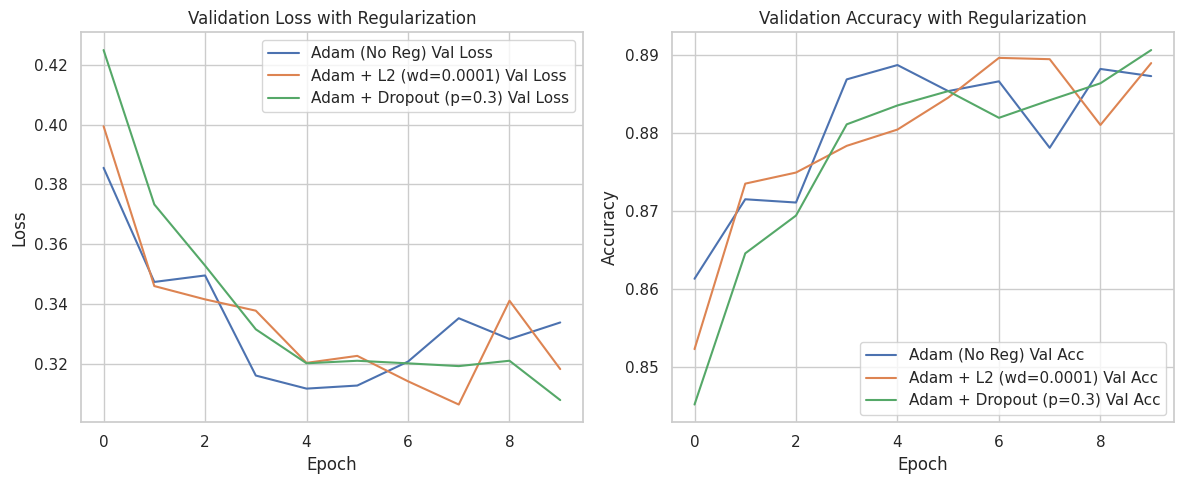

In [31]:
# --- Compare Regularization Effects ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_adam['val_loss'], label='Adam (No Reg) Val Loss') # From optimizer demo section
plt.plot(history_l2_reg['val_loss'], label=f'Adam + L2 (wd={WEIGHT_DECAY_VALUE}) Val Loss')
plt.plot(history_dropout['val_loss'], label=f'Adam + Dropout (p={DROPOUT_RATE}) Val Loss')
plt.title('Validation Loss with Regularization')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_adam['val_accuracy'], label='Adam (No Reg) Val Acc')
plt.plot(history_l2_reg['val_accuracy'], label=f'Adam + L2 (wd={WEIGHT_DECAY_VALUE}) Val Acc')
plt.plot(history_dropout['val_accuracy'], label=f'Adam + Dropout (p={DROPOUT_RATE}) Val Acc')
plt.title('Validation Accuracy with Regularization')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()